In [1]:
# Enable code formatting using external plugin: nb_black.
%reload_ext nb_black

<IPython.core.display.Javascript object>

# K-Nearest Neighbor (KNN)

Implement KNN algorithm.

### Objective

1. Implement KNN algorithm.
2. Given a query point <code>x<sub>q</sub></code>, predicts class of <code>x<sub>q</sub></code> data-point using KNN.

### Import and configure required libraries

In [2]:
# Data manipulation libraries
import numpy as np
import pandas as pd

# Data visualization libraries
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable

# Data modeling libraries

# General imports
import math

# Library versions used in below EDA.
print("NumPy version:", np.__version__)
print("Pandas version:", pd.__version__)
print("Matplotlib version:", matplotlib.__version__)
print("Seaborn version:", sns.__version__)

# Configure NumPy.
# Set `Line width` to Maximum 130 characters in the output, post which it will continue in next line.
np.set_printoptions(linewidth=130)

# Configure Pandas.
# Set display width to maximum 130 characters in the output, post which it will continue in next line.
pd.options.display.width = 130

# Configure Seaborn.
sns.set_style("whitegrid")  # Set white background with grid.
sns.set_palette("deep")  # Set color palette.
sns.set_context("paper", font_scale=1.5)  # Set font to scale 1.5 more than normal.

NumPy version: 1.21.5
Pandas version: 1.4.2
Matplotlib version: 3.5.1
Seaborn version: 0.11.2


<IPython.core.display.Javascript object>

#### Common functions

In [3]:
def is_empty(element) -> bool:
    """
    Function to check if input `element` is empty.

    Other than some special exclusions and inclusions,
    this function returns boolean result of Falsy check.
    """
    if (isinstance(element, int) or isinstance(element, float)) and element == 0:
        # Exclude 0 and 0.0 from the Falsy set.
        return False
    elif isinstance(element, str) and len(element.strip()) == 0:
        # Include string with only one or more empty space(s) into Falsy set.
        return True
    elif isinstance(element, bool):
        # Exclude False from the Falsy set.
        return False
    else:
        # Falsy check.
        return False if element else True


def all_zeros(numbers):
    """
    Function to check if all elements in the list are zero.
    """
    return all(n == 0 for n in numbers)


def get_count(items, key):
    """
    Function to count `key` in a list of items.
    """
    count = {}
    for index, item in enumerate(items):
        if is_empty(key(item)):
            raise ValueError(f"Specified key not found in the item at index: {index} in the list.")

        count[key(item)] = count.get(key(item), 0) + 1

    return count


ENABLE_LOG = False


def log(*args):
    """
    Function print when logging is enabled.
    """
    if ENABLE_LOG is True:
        print(*args)

<IPython.core.display.Javascript object>

### Load data-points from a `.csv` file

In [4]:
train_df = pd.read_csv("./Input/train.csv")
train_df.head()

,f1,f2,cl
0,1,8,1
1,1,10,1
2,2,4,1
3,2,14,1
4,2,7,1


<IPython.core.display.Javascript object>

In [5]:
train_df.shape

(50, 3)

<IPython.core.display.Javascript object>

In [6]:
train_df["cl"] = train_df["cl"].astype("category")
train_df["cl"].dtype

CategoricalDtype(categories=[1, 2], ordered=False)

<IPython.core.display.Javascript object>

### Plot data-points

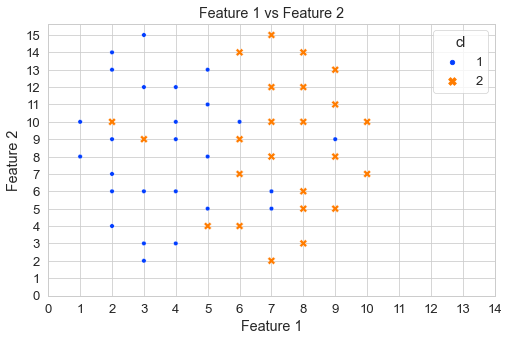

<IPython.core.display.Javascript object>

In [7]:
plt.figure(figsize=(8, 5))

sns.scatterplot(
    x="f1",
    y="f2",
    hue="cl",
    data=train_df,
    palette="bright",
    style="cl",
    markers=["o", "X"],
    size="cl",
    sizes=(60, 20),
)
plt.title("Feature 1 vs Feature 2")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.xticks(ticks=range(0, 15, 1))
plt.yticks(ticks=range(0, 16, 1))

plt.savefig("./Output/train-data-points.png")
plt.show()

## KNN Algorithm

* **STEP 1:** Get `K` nearest points to <code>x<sub>q</sub></code> in `D`.
    * For each data-point <code>x<sub>i</sub></code> in `D` calculate the distance between <code>x<sub>q</sub></code> and <code>x<sub>i</sub></code>.
    * Sort the data-points in increasing order of their distance from <code>x<sub>q</sub></code>.
    * Say `k = 3` and we got three points `X = {x1, x2, x3}`.
* **STEP 2:** Get class-labels of all data-points from STEP 1 and store it in `y`.
    * So `y = {y1, y2, y3}`
* **STEP 3:** Take majority vote of class from `y` and store it in `y_q`. 
* **STEP 4:** Declare <code>x<sub>q</sub></code> belongs to class `y_q`.

> **Note:**
> 1. If there are equal number of points from all the classes in `y`, it can create confusion while voting.
> 2. To avoid confusion in voting, `K` should preferably be **odd number**.
> 3. Its considered good practice to take `K` value as sqrt(N).

## STEP 1: Get `K` nearest points to <code>x<sub>q</sub></code> in <code>D<sub>n</sub></code>

There are different logics available to calculate distance between two points:

1. Euclidean Distance: : The L2 Norm
2. Manhattan Distance: The L1 Norm
2. Minkowski Distance: Lp Norm, where p > 0
3. Hamming Distance
4. Cosine Distance

In [8]:
def cosine_similarity(p1, p2):
    """
    Function to compute Cosine Distance between two points.
    """
    if all_zeros(p1) or all_zeros(p2):
        return 0

    dot_prod = (p1[0] * p2[0]) + (p1[1] * p2[1])
    p1_mag = math.sqrt(p1[0] ** 2 + p1[1] ** 2)
    p2_mag = math.sqrt(p2[0] ** 2 + p2[1] ** 2)

    return dot_prod / (p1_mag * p2_mag)


def cosine_distance(p1, p2):
    """
    Function to compute Cosine Distance between two points.
    """
    return 1 - cosine_similarity(p1, p2)


def manhattan_distance(p1, p2):
    """
    Function to compute Manhattan Distance between tow points.
    """
    return abs(p1[0] - p2[0]) + abs(p1[1] - p2[1])


def minkowski_distance(p1, p2, p=3):
    """
    Function to compute Euclidean Distance between two points.
    """
    diff = abs(p1[0] - p2[0]) ** p + abs(p1[1] - p2[1]) ** p
    return math.pow(diff, 1 / p)


def euclidean_distance(p1, p2):
    """
    Function to compute Euclidean Distance between two points.
    """
    return minkowski_distance(p1, p2, p=2)

<IPython.core.display.Javascript object>

Sort the data-points in increasing order of their distance from <code>x<sub>q</sub></code> and return top `K` points.

In [9]:
def get_k_nearest_points(S, P, K=5, algo_type=1):
    """
    Function to return list of points in the orders closest to `P`.
    """
    distances = []

    if algo_type == 1:
        log("Computing Euclidean Distance.")
        algo = euclidean_distance
    elif algo_type == 2:
        log("Computing Manhattan Distance.")
        algo = manhattan_distance
    elif algo_type == 3:
        log("Computing Minkowski Distance.")
        algo = minkowski_distance
    elif algo_type == 4:
        log("Computing Cosine Distance.")
        algo = cosine_distance
    else:
        raise ValueError(f"Invalid `algo_type` {algo_type}. Value should be in {1, 2, 3}.")

    for s in S:
        coordinate = list(s[0])

        distances.append(
            {
                "data-point": coordinate,
                "label": s[1],
                "distance": round(algo(coordinate, P), 6),
            }
        )

    return sorted(distances, key=lambda x: x["distance"])[:K]

<IPython.core.display.Javascript object>

Say `k = 3` and we got three points `X = {x1, x2, x3}`

In [10]:
xq = train_df[["f1", "f2"]].values
yq = train_df["cl"].values
S = list(zip(xq, yq))

P = (7.5, 11)

ENABLE_LOG = True

<IPython.core.display.Javascript object>

#### Euclidean Distance

In [11]:
knn = get_k_nearest_points(S, P, K=4)
knn

Computing Euclidean Distance.


[{'data-point': [7, 12], 'label': 2, 'distance': 1.118034},
 {'data-point': [7, 10], 'label': 2, 'distance': 1.118034},
 {'data-point': [8, 12], 'label': 2, 'distance': 1.118034},
 {'data-point': [8, 10], 'label': 2, 'distance': 1.118034}]

<IPython.core.display.Javascript object>

#### Manhattan Distance

In [12]:
get_k_nearest_points(S, P, algo_type=2)

Computing Manhattan Distance.


[{'data-point': [7, 12], 'label': 2, 'distance': 1.5},
 {'data-point': [7, 10], 'label': 2, 'distance': 1.5},
 {'data-point': [8, 12], 'label': 2, 'distance': 1.5},
 {'data-point': [8, 10], 'label': 2, 'distance': 1.5},
 {'data-point': [9, 11], 'label': 2, 'distance': 1.5}]

<IPython.core.display.Javascript object>

#### Minkowski Distance

In [13]:
get_k_nearest_points(S, P, K=6, algo_type=3)

Computing Minkowski Distance.


[{'data-point': [7, 12], 'label': 2, 'distance': 1.040042},
 {'data-point': [7, 10], 'label': 2, 'distance': 1.040042},
 {'data-point': [8, 12], 'label': 2, 'distance': 1.040042},
 {'data-point': [8, 10], 'label': 2, 'distance': 1.040042},
 {'data-point': [9, 11], 'label': 2, 'distance': 1.5},
 {'data-point': [6, 10], 'label': 1, 'distance': 1.635533}]

<IPython.core.display.Javascript object>

#### Cosine Distance

In [14]:
get_k_nearest_points(S, P, algo_type=4)

Computing Cosine Distance.


[{'data-point': [9, 13], 'label': 2, 'distance': 2.5e-05},
 {'data-point': [4, 6], 'label': 1, 'distance': 5.4e-05},
 {'data-point': [6, 9], 'label': 2, 'distance': 5.4e-05},
 {'data-point': [8, 12], 'label': 2, 'distance': 5.4e-05},
 {'data-point': [7, 10], 'label': 2, 'distance': 7.6e-05}]

<IPython.core.display.Javascript object>

#### Relation b/w Euclidean Distance & Cosine Distance for unit vectors

```
euclidean_distance = (2 * cosine_distance) ^ (1/2)
```

In [15]:
ed = euclidean_distance([1, 0], [0, 1])
cd = cosine_distance([1, 0], [0, 1])

print("Euclidean distance:", round(ed, 6))
print("Cosine distance:", round(cd, 6))
print("Ed from Cd for unit vectors:", round(math.sqrt(2 * cd), 6))  # or (2 * cd) ** (1/2)

Euclidean distance: 1.414214
Cosine distance: 1.0
Ed from Cd for unit vectors: 1.414214


<IPython.core.display.Javascript object>

## STEP 2: Get class-labels of all data-points from STEP 1 and store it in `y`

`knn` contains K-nearest neighbors obtained using Euclidean distance.

In [16]:
knn

[{'data-point': [7, 12], 'label': 2, 'distance': 1.118034},
 {'data-point': [7, 10], 'label': 2, 'distance': 1.118034},
 {'data-point': [8, 12], 'label': 2, 'distance': 1.118034},
 {'data-point': [8, 10], 'label': 2, 'distance': 1.118034}]

<IPython.core.display.Javascript object>

Logic to compute majority vote.

In [17]:
def majority_vote(knn):
    if is_empty(knn):
        raise ValueError("Class list is empty.")

    cl_count = get_count(knn, lambda n: n.get("label", None))
    log("Class count:", cl_count)

    cl_sorted = sorted(cl_count.items(), key=lambda x: x[1], reverse=True)
    log("Class sorted:", cl_sorted)

    return cl_sorted[0]

<IPython.core.display.Javascript object>

Get class name appearing most number of times in `knn`.

In [18]:
ENABLE_LOG = True

try:
    class_label, count = majority_vote(knn)
    print("Class label:", class_label, "Count:", count)
except ValueError as ve:
    print("Error:", ve)

Class count: {2: 4}
Class sorted: [(2, 4)]
Class label: 2 Count: 4


<IPython.core.display.Javascript object>

## Test implementation of KNN algorithm

#### Plot Train and Test data-points

In [19]:
test_df = pd.read_csv("./Input/test.csv")
test_df.head()

,f1,f2,cl
0,5.0,6.0,1
1,4.0,5.0,1
2,5.0,9.0,1
3,3.0,10.0,1
4,2.5,9.0,1


<IPython.core.display.Javascript object>

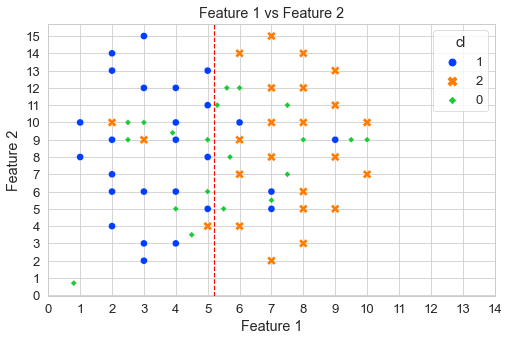

<IPython.core.display.Javascript object>

In [20]:
test_df_temp = test_df.copy()
test_df_temp["cl"] = 0

plt.figure(figsize=(8, 5))

sns.scatterplot(
    x="f1",
    y="f2",
    hue="cl",
    data=pd.concat([train_df, test_df_temp]),
    palette="bright",
    hue_order=[1, 2, 0],
    style="cl",
    markers=["D", "o", "X"],
    size="cl",
    sizes=(20, 80),
)
plt.title("Feature 1 vs Feature 2")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.xticks(ticks=range(0, 15, 1))
plt.yticks(ticks=range(0, 16, 1))
plt.axvline(5.2, linestyle="--", color="r", label="90th percentile")

plt.savefig("./Output/train-n-test-data-points.png")
plt.show()

1. Every green point on the **left side** of red line belongs to class **`1` - Blue**.
2. Every green point (except `(5.7, 8)`) on the **right side** of red line belongs to class **`2` - Orange**.
3. Green data-point **`(5.7, 8)`** on the right of red line belongs to class `1` - Blue.

### Training model on KNN

In [21]:
ENABLE_LOG = False
table = PrettyTable(["Data-Point", "Actual Class", "Predicted Class", "Failed"])

try:
    acc = 0
    for index, row in test_df.iterrows():
        x_q = list(row[:2])  # Query point
        acl = int(row[-1])  # Actual class label

        # STEP 1: Get K-nearest neighbors.
        knn = get_k_nearest_points(S, x_q, K=5)

        # STEP 2: Get class with majority vote.
        pcl, count = majority_vote(knn)  # Predicted class label and its votes

        # STEP 3: Calculate accuracy.
        sym = "X"
        if acl == pcl:
            acc += 1
            sym = ""

        table.add_row([x_q, acl, pcl, sym])

    print("Training model using train dataset:")
    print(table)

except ValueError as ve:
    print("Error:", ve)

Training model using train dataset:
+-------------+--------------+-----------------+--------+
|  Data-Point | Actual Class | Predicted Class | Failed |
+-------------+--------------+-----------------+--------+
|  [5.0, 6.0] |      1       |        1        |        |
|  [4.0, 5.0] |      1       |        1        |        |
|  [5.0, 9.0] |      1       |        1        |        |
| [3.0, 10.0] |      1       |        1        |        |
|  [2.5, 9.0] |      1       |        1        |        |
| [2.5, 10.0] |      1       |        1        |        |
|  [5.7, 8.0] |      1       |        2        |   X    |
|  [4.5, 3.5] |      1       |        1        |        |
|  [3.9, 9.4] |      1       |        1        |        |
|  [0.8, 0.7] |      1       |        1        |        |
| [7.5, 11.0] |      2       |        2        |        |
| [10.0, 9.0] |      2       |        2        |        |
|  [9.5, 9.0] |      2       |        2        |        |
|  [8.0, 9.0] |      2       |      

<IPython.core.display.Javascript object>

### Accuracy of KNN algorithm

In [22]:
print("Accuracy of model on test dataset.")
print("Total number of correct predictions:", acc)
print(f"Accuracy: {round(acc / len(test_df) * 100, 1)}%")

Accuracy of model on test dataset.
Total number of correct predictions: 15
Accuracy: 75.0%


<IPython.core.display.Javascript object>